In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.regularizers import l2
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal

# 1. Carregar conjunto de dados

In [737]:
## Carregando os dados
df = pd.read_csv("data/train.csv")

# 2. Extração e tratamento de características

## 2.1 Criação de variável 'strata' para estratificação dos dados

In [738]:
##Criando variável para fazer divisão ideal dos dados
df['strata'] = df['Pclass'].astype(str) + "_" + \
               df['Survived'].astype(str)

## 2.2 Extração de características 

In [739]:
##Engenharia de features
#Ajuste no nome por título
df["Name"] = df["Name"].str.extract(r',\s*([^\.]+)\.')

##Se possui cabine múltipla
df['Cabin_Multiple'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
df['Cabin_Multiple'] = df['Cabin_Multiple'].apply(lambda x: 0 if x == 0 else 1)

##Prefixo da Cabine
df['Cabin_Pref'] = df['Cabin'].apply(lambda x: str(x)[0])

##Se o Ticket é numérico
df['Numeric_Ticket'] = df["Ticket"].apply(lambda x: 1 if x.isnumeric() else 0)

##Prefixo do Ticket
df["Prefix_Ticket"] = df["Ticket"].str.extract(r"^(.*?)(?=\s\d)")
df["Prefix_Ticket"] = df["Prefix_Ticket"].str.strip()
df["Prefix_Ticket"] = df["Prefix_Ticket"].fillna("n")

## 2.3 Tratamento de características

In [740]:
##Tratamento de dados
##Binarizando coluna 'Name'
df = pd.get_dummies(df, columns=['Name'], prefix='Name', dtype=int)

##Binarizar 'Sex'
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

##Binarizando 'Embarked'
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df = pd.get_dummies(df, columns=['Embarked'], prefix='Embarked', dtype=int)

##Binarizando 'Cabin_Pref'
df = pd.get_dummies(df, columns=['Cabin_Pref'], prefix='Cabin_Pref', dtype=int)

##Binarizando 'Prefix_Ticket'
df = pd.get_dummies(df, columns=['Prefix_Ticket'], prefix='Prefix_Ticket', dtype=int)

In [741]:
##Tratamento de Nulos da idade
com_idade = df[df['Age'].notnull()]
sem_idade = df[df['Age'].isnull()]

#Baseear a escolha da idade por
colunas_preditoras = ['Parch', 'Pclass', 'Sex', 'Cabin_Multiple', 'Fare', 'Name_Master',
 'Name_Miss',
 'Name_Mr',
 'Name_Mrs']

#Treino
modelo = RandomForestRegressor()
modelo.fit(com_idade[colunas_preditoras], com_idade['Age'])

#Predict
idades_previstas = modelo.predict(sem_idade[colunas_preditoras])

#Preenchuer
df.loc[df['Age'].isnull(), 'Age'] = idades_previstas

In [742]:
##'Cabin'
df = df.drop(columns = {'Cabin'})

In [743]:
columns = ['strata', 'Pclass',
 'Age',
 'Parch', 
 'SibSp', 
 'Fare',
 'Survived',
 'Cabin_Multiple',
 'Sex',
 'Name_Miss',
 'Name_Mr',
 'Name_Mrs',
 'Embarked_C',
 'Embarked_S',
 'Embarked_Q']

df = df[columns]
df

,strata,Pclass,Age,Parch,SibSp,Fare,Survived,Cabin_Multiple,Sex,Name_Miss,Name_Mr,Name_Mrs,Embarked_C,Embarked_S,Embarked_Q
0,3_0,3,22.000000,0,1,7.2500,0,0,1,0,1,0,0,1,0
1,1_1,1,38.000000,0,1,71.2833,1,1,0,0,0,1,1,0,0
2,3_1,3,26.000000,0,0,7.9250,1,0,0,1,0,0,0,1,0
3,1_1,1,35.000000,0,1,53.1000,1,1,0,0,0,1,0,1,0
4,3_0,3,35.000000,0,0,8.0500,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2_0,2,27.000000,0,0,13.0000,0,0,1,0,0,0,0,1,0
887,1_1,1,19.000000,0,0,30.0000,1,1,0,1,0,0,0,1,0
888,3_0,3,7.783333,2,1,23.4500,0,0,0,1,0,0,0,1,0
889,1_1,1,26.000000,0,0,30.0000,1,1,1,0,1,0,1,0,0


In [744]:
df['Cabin_Multiple'].value_counts()

Cabin_Multiple
0    687
1    204
Name: count, dtype: int64

In [745]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   strata          891 non-null    object 
 1   Pclass          891 non-null    int64  
 2   Age             891 non-null    float64
 3   Parch           891 non-null    int64  
 4   SibSp           891 non-null    int64  
 5   Fare            891 non-null    float64
 6   Survived        891 non-null    int64  
 7   Cabin_Multiple  891 non-null    int64  
 8   Sex             891 non-null    int64  
 9   Name_Miss       891 non-null    int64  
 10  Name_Mr         891 non-null    int64  
 11  Name_Mrs        891 non-null    int64  
 12  Embarked_C      891 non-null    int64  
 13  Embarked_S      891 non-null    int64  
 14  Embarked_Q      891 non-null    int64  
dtypes: float64(2), int64(12), object(1)
memory usage: 104.5+ KB


# 3. Divisão do conjunto de dados

In [746]:
# Separar X e y
X = df.drop(columns=['Survived', 'strata'])
y = df['Survived']
strata = df['strata']

In [747]:
# 2. Coluna sensível (única)
sensitive_col = 'Name_Mr'

# 3. Separar colunas para normalizar (excluindo a coluna sensível)
cols_to_normalize = [col for col in X.columns if col != sensitive_col]

In [ ]:
# 4. Normalizar antes da divisão (sem incluir coluna sensível)
scaler = MinMaxScaler()
## scaler = RobustScaler()
## scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[cols_to_normalize] = scaler.fit_transform(X_scaled[cols_to_normalize])

In [749]:
# 5. Dividir os dados normalizados
X_train, X_temp, y_train, y_temp, strata_train, strata_temp = train_test_split(
    X_scaled, y, strata,
    test_size=0.3,
    stratify=strata,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=strata_temp,
    random_state=42
)

In [750]:
X.columns

Index(['Pclass', 'Age', 'Parch', 'SibSp', 'Fare', 'Cabin_Multiple', 'Sex',
       'Name_Miss', 'Name_Mr', 'Name_Mrs', 'Embarked_C', 'Embarked_S',
       'Embarked_Q'],
      dtype='object')

In [751]:
df_test_raw = X_test
df_raw_train = X_train

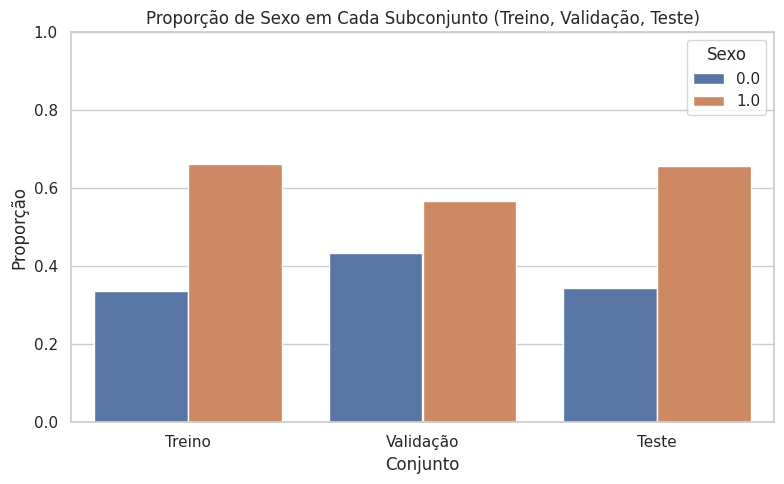

In [752]:
# Criar um DataFrame auxiliar com os conjuntos e seus respectivos sexos
def create_summary(df, name, coluna):
    return df[coluna].value_counts(normalize=True).rename_axis(coluna).reset_index(name='Proportion').assign(Subset=name)

summary_train = create_summary(X_train, 'Treino', 'Sex')
summary_val = create_summary(X_val, 'Validação', 'Sex')
summary_test = create_summary(X_test, 'Teste', 'Sex')

# Combinar os dados em um único DataFrame
summary_df = pd.concat([summary_train, summary_val, summary_test])

# Plotar
plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x='Subset', y='Proportion', hue='Sex')
plt.title('Proporção de Sexo em Cada Subconjunto (Treino, Validação, Teste)')
plt.ylim(0, 1)
plt.ylabel('Proporção')
plt.xlabel('Conjunto')
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

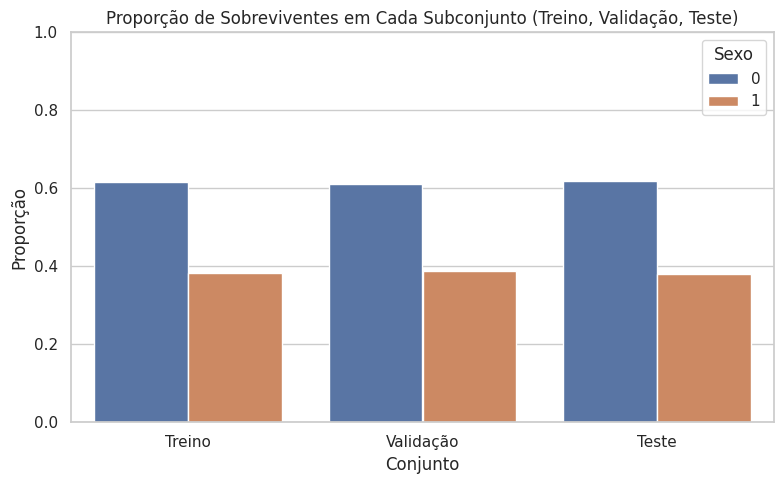

In [753]:
# Transformar as Series y_* em DataFrames com coluna nomeada
y_train_df = y_train.to_frame(name='Survived')
y_val_df = y_val.to_frame(name='Survived')
y_test_df = y_test.to_frame(name='Survived')

# Agora sim, aplicar a função corretamente
summary_train = create_summary(y_train_df, 'Treino', 'Survived')
summary_val = create_summary(y_val_df, 'Validação', 'Survived')
summary_test = create_summary(y_test_df, 'Teste', 'Survived')

# Combinar os dados em um único DataFrame
summary_df = pd.concat([summary_train, summary_val, summary_test])

# Plotar
plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x='Subset', y='Proportion', hue='Survived')
plt.title('Proporção de Sobreviventes em Cada Subconjunto (Treino, Validação, Teste)')
plt.ylim(0, 1)
plt.ylabel('Proporção')
plt.xlabel('Conjunto')
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

# 4. Normalização

In [754]:
# 6. Função para gerar sample weights com base em UMA coluna sensível
def compute_sample_weights_single(df, col):
    group_counts = df[col].value_counts()
    total = len(df)
    weights = total / (len(group_counts) * group_counts)
    sample_weights = df[col].map(weights).values
    return sample_weights

In [755]:
sample_weights_train = compute_sample_weights_single(X_train, sensitive_col)

# 5. Treinamento

In [757]:
# 8. Remover coluna sensível dos dados de entrada
X_train_input = X_train.drop(columns=[sensitive_col]).values
X_val_input = X_val.drop(columns=[sensitive_col]).values
X_test_input = X_test.drop(columns=[sensitive_col]).values

In [758]:
##Modelo MLP
model = Sequential([
    Dense(64, input_dim=X_train_input.shape[1], activation='relu',
          kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    Dense(64, activation='relu',
          kernel_initializer='he_normal', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))  # saída não precisa de He
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/home/guilherme/ECP/redes_neurais/P3/G_FilipePinheiro_GuilhermeMatos_Titanic/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [759]:
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = model.fit(
    X_train_input, y_train,
    sample_weight=sample_weights_train,
    validation_data=(X_val_input, y_val),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5010 - loss: 3.1214 - val_accuracy: 0.8209 - val_loss: 2.7918
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7961 - loss: 2.7597 - val_accuracy: 0.8358 - val_loss: 2.5170
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7670 - loss: 2.5106 - val_accuracy: 0.7985 - val_loss: 2.2999
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8000 - loss: 2.2531 - val_accuracy: 0.7985 - val_loss: 2.1079
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7608 - loss: 2.1012 - val_accuracy: 0.7910 - val_loss: 1.9453
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7861 - loss: 1.9391 - val_accuracy: 0.7985 - val_loss: 1.7962
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7826 - loss: 1.8045 - val_accuracy: 0.7985 - val_loss: 1.6681
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7762 - loss: 1.6829 - val_accuracy: 0.7985 - v

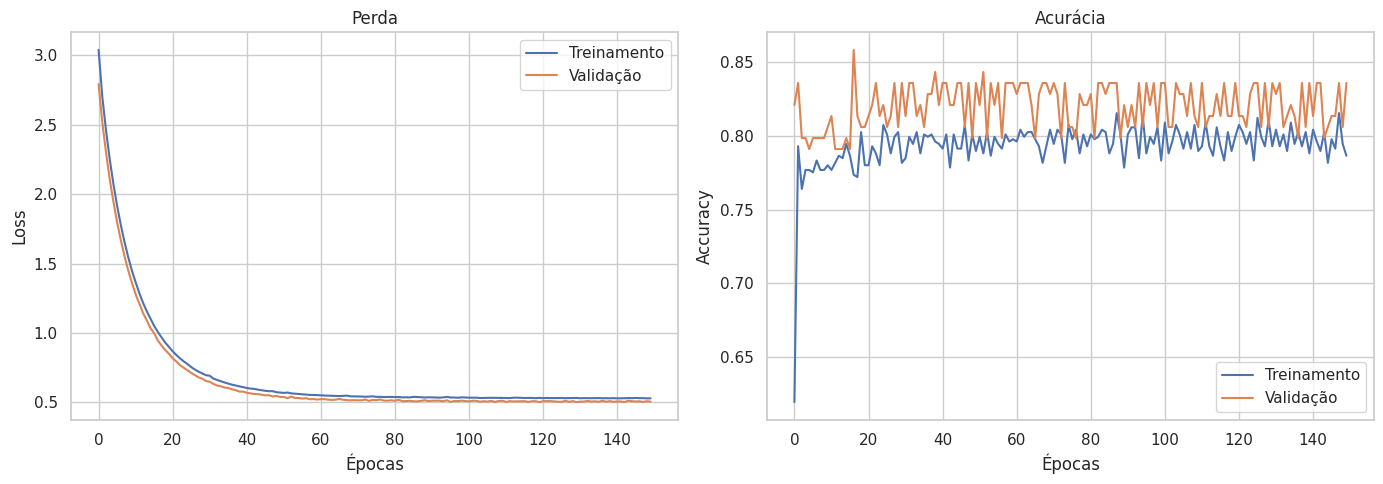

In [760]:
##Plots
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Perda")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Acurácia")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        83
           1       0.86      0.73      0.79        51

    accuracy                           0.85       134
   macro avg       0.85      0.83      0.84       134
weighted avg       0.85      0.85      0.85       134

Matriz de Confusão:
[[77  6]
 [14 37]]


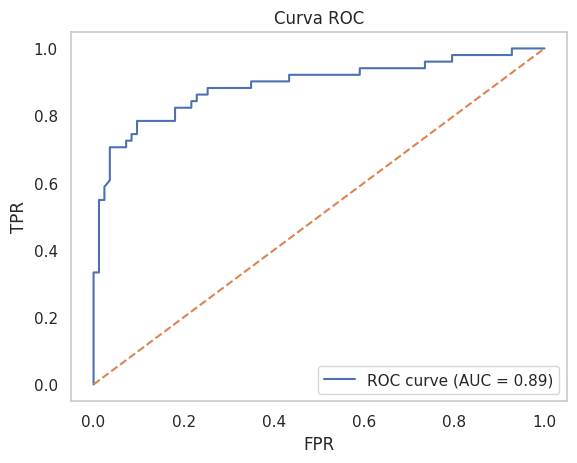

In [761]:
##Avaliação
y_pred_probs = model.predict(X_test_input).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 6. Análise de erro

/tmp/ipykernel_116189/3118115229.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_class = df_result.groupby('Pclass').apply(
/tmp/ipykernel_116189/3118115229.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_class, x='Pclass', y='accuracy', palette='viridis')


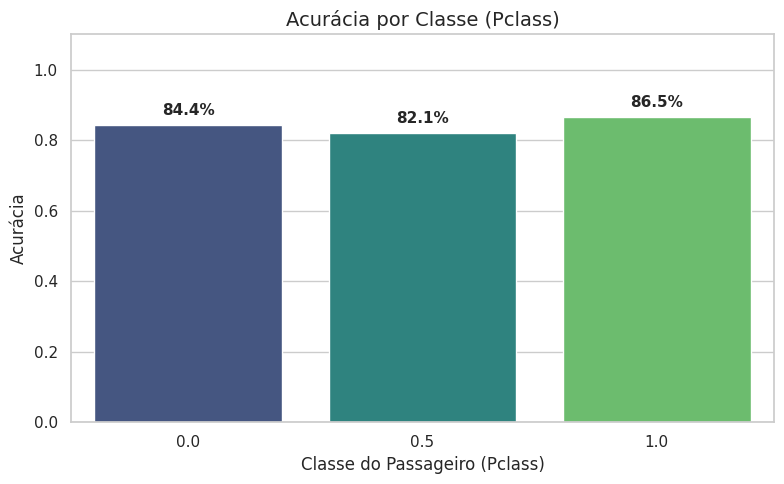

In [762]:
#@Juntar com a coluna Pclass (que vem da versão original dos dados)
df_result = pd.DataFrame({
    'Pclass': df_test_raw['Pclass'].values,
    'y_true': y_test,
    'y_pred': y_pred
})
##Calcular acurácia por Pclass
acc_by_class = df_result.groupby('Pclass').apply(
    lambda g: accuracy_score(g['y_true'], g['y_pred'])
).reset_index(name='accuracy')

##Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=acc_by_class, x='Pclass', y='accuracy', palette='viridis')

#Adicionar porcentagens no topo das barras
for i, row in acc_by_class.iterrows():
    acc_percent = f"{row['accuracy']*100:.1f}%"
    ax.text(i, row['accuracy'] + 0.02, acc_percent, ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Acurácia por Classe (Pclass)', fontsize=14)
plt.xlabel('Classe do Passageiro (Pclass)', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.ylim(0, 1.1)  # Deixar espaço para o texto acima das barras
plt.tight_layout()
plt.show()

In [763]:
def check_accuracy(coluna):
    df_result = pd.DataFrame({
        coluna: df_test_raw[coluna].values,
        'y_true': y_test,
        'y_pred': y_pred
    })
    
    ##Calcular acurácia por sexo
    acc_by_sex = df_result.groupby(coluna).apply(
        lambda g: accuracy_score(g['y_true'], g['y_pred'])
    ).reset_index(name='accuracy')
    
    ##Plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')
    
    #Adicionar porcentagens no topo das barras
    for i, row in acc_by_sex.iterrows():
        acc_percent = f"{row['accuracy']*100:.1f}%"
        ax.text(i, row['accuracy'] + 0.02, acc_percent, ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.title(f'Acurácia por {coluna}', fontsize=14)
    plt.xlabel(coluna, fontsize=12)
    plt.ylabel('Acurácia', fontsize=12)
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_116189/1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
/tmp/ipykernel_116189/1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


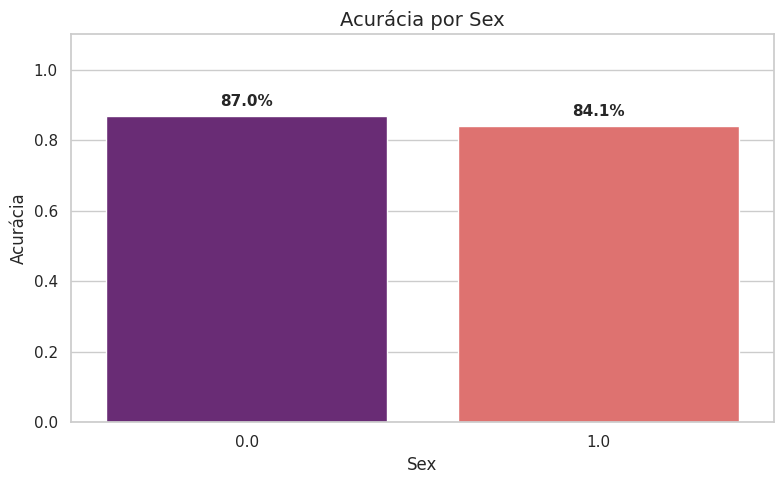

In [764]:
check_accuracy('Sex')

In [765]:
columns

['strata',
 'Pclass',
 'Age',
 'Parch',
 'SibSp',
 'Fare',
 'Survived',
 'Cabin_Multiple',
 'Sex',
 'Name_Miss',
 'Name_Mr',
 'Name_Mrs',
 'Embarked_C',
 'Embarked_S',
 'Embarked_Q']

/tmp/ipykernel_116189/1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
/tmp/ipykernel_116189/1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


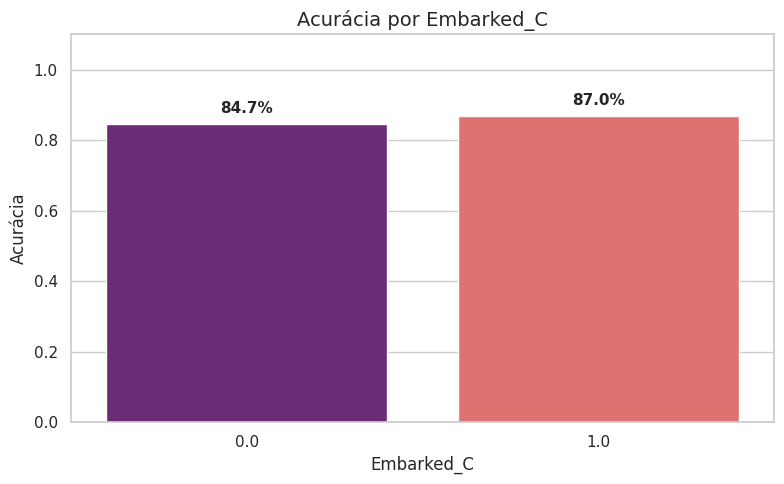

In [766]:
check_accuracy('Embarked_C')

/tmp/ipykernel_116189/1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
/tmp/ipykernel_116189/1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


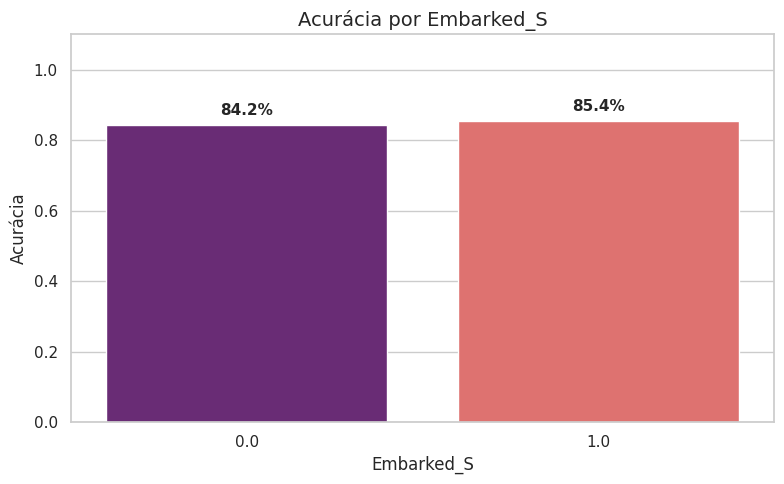

In [767]:
check_accuracy('Embarked_S')

/tmp/ipykernel_116189/1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
/tmp/ipykernel_116189/1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


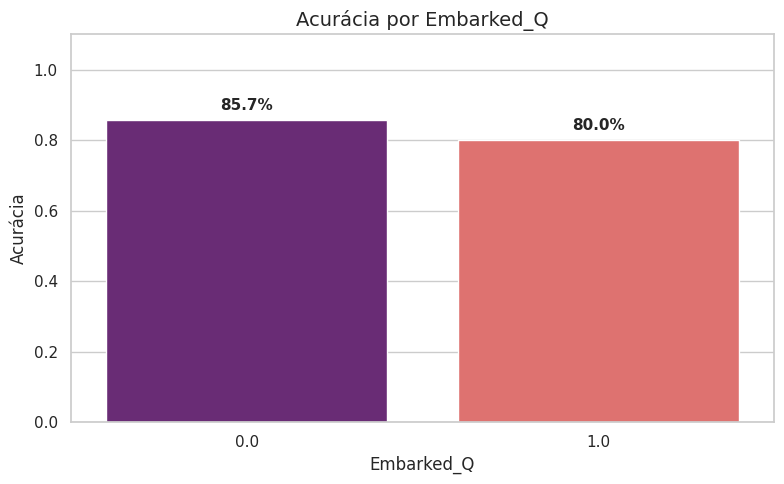

In [768]:
check_accuracy('Embarked_Q')

/tmp/ipykernel_116189/1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
/tmp/ipykernel_116189/1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


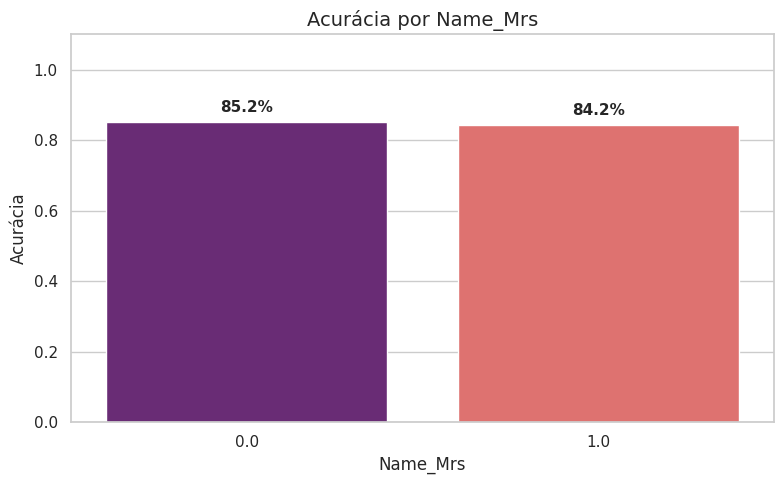

In [769]:
check_accuracy('Name_Mrs')

/tmp/ipykernel_116189/1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
/tmp/ipykernel_116189/1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


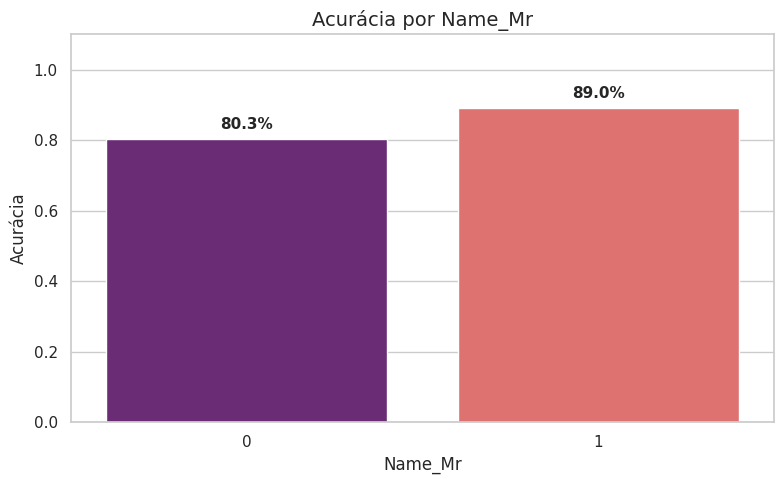

In [770]:
check_accuracy('Name_Mr')

/tmp/ipykernel_116189/1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
/tmp/ipykernel_116189/1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


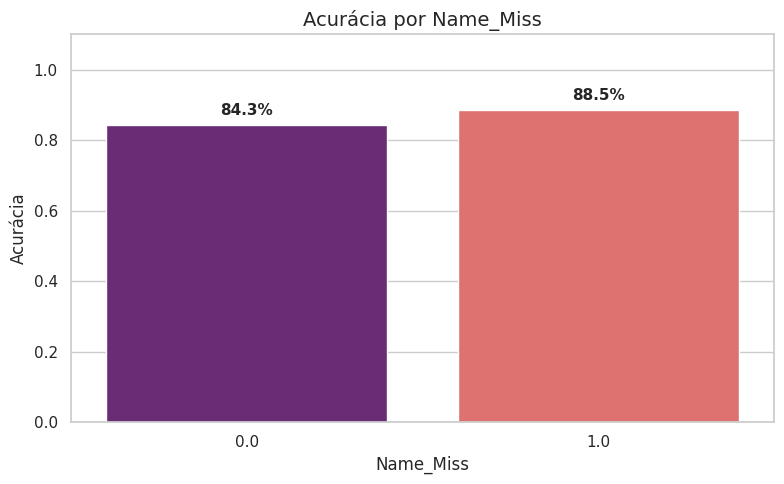

In [771]:
check_accuracy('Name_Miss')

/tmp/ipykernel_116189/1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
/tmp/ipykernel_116189/1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


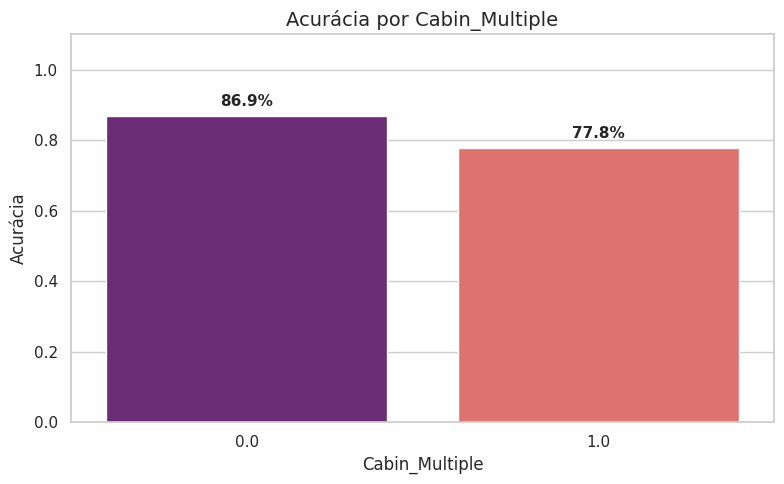

In [772]:
check_accuracy('Cabin_Multiple')

/tmp/ipykernel_116189/1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
/tmp/ipykernel_116189/1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


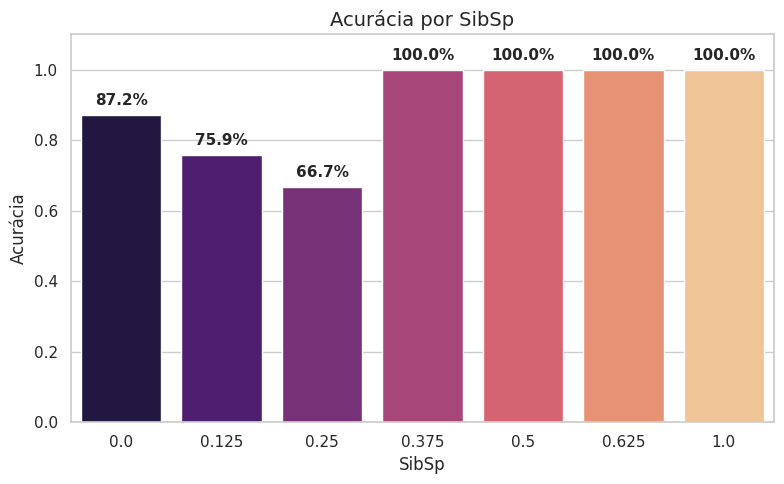

In [773]:
check_accuracy('SibSp')

/tmp/ipykernel_116189/1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
/tmp/ipykernel_116189/1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


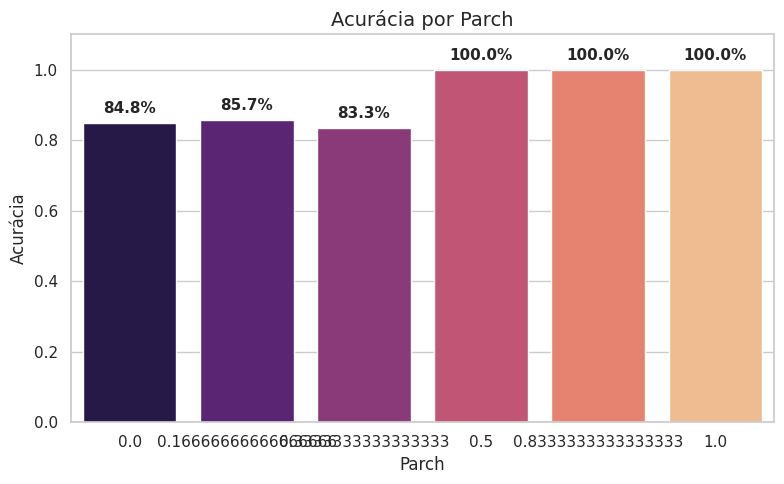

In [774]:
check_accuracy('Parch')

In [775]:
df_raw_train['Pclass'].value_counts()

Pclass
1.0    343
0.0    151
0.5    129
Name: count, dtype: int64

In [776]:
pd.crosstab(df_raw_train['Cabin_Multiple'], y_train, normalize='index')


Survived,0,1
Cabin_Multiple,,
0.0,0.699580,0.300420
1.0,0.346939,0.653061


# Avaliação em dados de teste fictícios

In [777]:
## Carregando os dados
df_test = pd.read_csv("data/test_fake.csv")

Index(['Pclass', 'Age', 'Parch', 'SibSp', 'Fare', 'Cabin_Multiple', 'Sex',
       'Name_Master', 'Name_Miss', 'Name_Mr', 'Name_Mrs', 'Embarked_C',
       'Embarked_S', 'Embarked_Q', 'Cabin_Pref_B', 'Cabin_Pref_C',
       'Cabin_Pref_D', 'Cabin_Pref_E', 'Cabin_Pref_n', 'Prefix_Ticket_PC'],
      dtype='object')

In [778]:
df_test.drop(columns=['PassengerId'], inplace=True)

In [779]:
df_test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,"Smith, Mrs. Anna",female,30,1,0,PC 17599,120.00,B28,C,1
1,3,"Doe, Miss. Mary",female,25,0,0,A/5 21171,7.25,NaN,S,1
2,1,"Brown, Master. Henry",male,6,2,2,113781,150.00,C83,C,1
3,3,"Lee, Miss. Sophie",female,8,1,3,W./C. 6608,21.00,NaN,S,1
4,1,"Johnson, Mr. Robert",male,40,0,0,PC 17756,108.90,C85,S,0
5,3,"Williams, Mr. John",male,35,0,0,373450,8.05,NaN,S,0
6,1,"Taylor, Mrs. Grace",female,68,0,1,PC 17483,120.00,E31,C,1
7,3,"Clark, Mrs. Ellen",female,70,0,0,330877,7.75,NaN,Q,0
8,1,"Anderson, Mr. George",male,72,0,1,113798,80.00,D33,S,0
9,3,"Martins, Mr. Pedro",male,74,0,0,345763,6.95,NaN,S,0


In [780]:
# Cabin_Multiple: se houver mais de uma cabine listada
df_test['Cabin_Multiple'] = df_test['Cabin'].apply(lambda x: 1 if pd.notna(x) and ' ' in str(x) else 0)

# Título (prefixo do nome)
df_test['Title'] = df_test['Name'].str.extract(r',\s*([^\.]*)\.', expand=False)

# One-hot titles
df_test['Name_Miss'] = (df_test['Title'] == 'Miss').astype(int)
df_test['Name_Mr'] = (df_test['Title'] == 'Mr').astype(int)
df_test['Name_Mrs'] = (df_test['Title'] == 'Mrs').astype(int)

# One-hot encoding de Embarked
embarked_dummies = pd.get_dummies(df_test['Embarked'], prefix='Embarked')
for col in ['Embarked_C', 'Embarked_S', 'Embarked_Q']:
    df_test[col] = embarked_dummies.get(col, pd.Series(0, index=df_test.index))

# Cabin prefix (primeira letra da cabine)
df_test['Cabin_Pref'] = df_test['Cabin'].astype(str).str[0]
cabin_dummies = pd.get_dummies(df_test['Cabin_Pref'], prefix='Cabin_Pref')
for col in ['B', 'C', 'D', 'E', 'n']:
    df_test[f'Cabin_Pref_{col}'] = cabin_dummies.get(f'Cabin_Pref_{col}', pd.Series(0, index=df_test.index))

# Prefix_Ticket_PC
df_test['Prefix_Ticket_PC'] = df_test['Ticket'].astype(str).str.startswith('PC').astype(int)

# Converter sexo para numérico
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1})

# Converte todas as colunas booleanas para int
bool_cols = df_test.select_dtypes(include='bool').columns
df_test[bool_cols] = df_test[bool_cols].astype(int)

# Define colunas finais de entrada (mantém Survived separada)
final_features = [
    'Pclass', 'Age', 'Parch', 'SibSp', 'Fare', 'Cabin_Multiple', 'Sex',
    'Name_Mr', 'Name_Miss', 'Name_Mrs',
    'Embarked_C', 'Embarked_S', 'Embarked_Q',
]

# Garante que apenas essas colunas + Survived permaneçam
cols_to_keep = final_features + ['Survived']
df_test = df_test[cols_to_keep].copy()


In [781]:
df_test

,Pclass,Age,Parch,SibSp,Fare,Cabin_Multiple,Sex,Name_Mr,Name_Miss,Name_Mrs,Embarked_C,Embarked_S,Embarked_Q,Survived
0,1,30,0,1,120.00,0,1,0,0,1,1,0,0,1
1,3,25,0,0,7.25,0,1,0,1,0,0,1,0,1
2,1,6,2,2,150.00,0,0,0,0,0,1,0,0,1
3,3,8,3,1,21.00,0,1,0,1,0,0,1,0,1
4,1,40,0,0,108.90,0,0,1,0,0,0,1,0,0
5,3,35,0,0,8.05,0,0,1,0,0,0,1,0,0
6,1,68,1,0,120.00,0,1,0,0,1,1,0,0,1
7,3,70,0,0,7.75,0,1,0,0,1,0,0,1,0
8,1,72,1,0,80.00,0,0,1,0,0,0,1,0,0
9,3,74,0,0,6.95,0,0,1,0,0,0,1,0,0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.60      0.60      0.60         5

    accuracy                           0.60        10
   macro avg       0.60      0.60      0.60        10
weighted avg       0.60      0.60      0.60        10

Matriz de Confusão:
[[3 2]
 [2 3]]


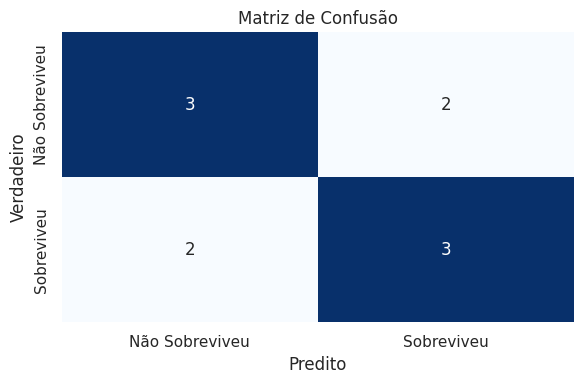

In [782]:
# Corrigir: precisa aplicar o mesmo scaler usado no treino
X_test = df_test.drop(columns=['Survived', 'Name_Mr'])
X_test_scaled = scaler.transform(X_test)  # <- normalização aqui!

y_test = df_test['Survived']

# Previsão dos dados de teste
y_pred_probs = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

# Relatório
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(cm)

# Plotando a matriz de confusão como imagem .png
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Sobreviveu', 'Sobreviveu'],
            yticklabels=['Não Sobreviveu', 'Sobreviveu'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.savefig('matriz_confusao.png')  # Salva como imagem .png
plt.show()
